## 特徴量のカンペはこちら ⇒ https://docs.google.com/spreadsheets/d/1T59ieP110cFg8MfOtIbW2M60iWuSwnIf/edit?usp=share_link&ouid=111727008586725963366&rtpof=true&sd=true

## Kaggle用データのインポート

In [112]:
from google.colab import drive
drive.mount('/content/drive')

COMPETITION = "house-prices-advanced-regression-techniques"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/kaggle"

import os

if not(os.path.exists(WORK_DIR)):
  os.mkdir(WORK_DIR)
os.chdir(WORK_DIR)

from google.colab import files
files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"droeloe","key":"c330037c8e955090c87e6872ec333b32"}'}

In [113]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c {COMPETITION} # copy from competition page!
!unzip -o {COMPETITION}
!rm {COMPETITION}.zip

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 27.7MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## ライブラリのインポート

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from numpy import mean, std

import statsmodels.formula.api as smf
from statsmodels.stats import power
import statsmodels.api as sm
from scipy import stats
import math
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE) # seabornのデフォルトの色を変更する
BACKCOLOR = '#f6f5f5'

from scipy.special import boxcox1p
from IPython.core.display import HTML
from scipy.stats import norm, skew #for some statistics
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedKFold
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

### User modules

In [115]:
# 並び替え検定用の関数
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

In [116]:
# permutation test
def permutation_test(data, var, target):

  vA = data[var].dropna().unique()[0]
  vB = data[var].dropna().unique()[1]
  mean_a = data[data[var] == vA][target].mean()
  mean_b = data[data[var] == vB][target].mean()
  print(f"{target} mean value with {var}={vA}: {mean_a}")
  print(f"{target} mean value with {var}={vB}: {mean_b}")
  print(f"{target} observed difference between ({var}={vA}) and ({var}={vB}): {mean_b - mean_a}")
  nA = data[data[var] == vA].shape[0]
  nB = data[data[var] == vB].shape[0]

  random.seed(1)
  perm_diffs = pd.Series([perm_fun(data[target], nA, nB) for _ in range(1000)])
  perm_diffs = perm_diffs.dropna()

  fig, ax = plt.subplots(figsize=(5, 5))
  ax.hist(perm_diffs, bins=11, rwidth=0.9)
  ax.axvline(x = mean_b - mean_a, color='black', lw=2)
  ax.text(mean_b - mean_a, 10, 'Observed\ndifference', bbox={'facecolor':'white'})
  ax.set_xlabel(f'{var} differences')
  ax.set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

  perm_diffs = np.array(perm_diffs)
  print('p-value: ', (np.mean(perm_diffs > mean_b - mean_a)))

In [117]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [118]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=13)
        ax[i].set_ylabel('Count', weight='bold', size=13)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    plt.show()

In [119]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=train, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

In [120]:
# ANOVA using permutation test
# Image size が ～～～ のエラーが出た場合は logx = True に設定する
def anova_perm(data, var, target, logx=False):

  # Creating crosstab
  crosstb = pd.crosstab(data[var], data[target])
  
  # Creating barplot
  # pl = crosstb.plot(kind="bar", stacked=True, rot=0)

  for col in data[var].unique():
      try:
          true_ratio = len(data[(data[var]==col)&(data[target]==True)]) / len(data[data[var]==col])
      except:
          break
      print(col, true_ratio)

  observed_variance = data.groupby(var).mean().var()[target] # グループごとの平均値を求め、その平均値の分散を計算している
  print('Observed means:', data.groupby(var).mean()[target].values.ravel()) # ravel: 横方向の1次元のベクトルを返す
  print('Variance:', observed_variance)
  # Permutation test example with stickiness
  def perm_test(data):
      data = data.copy()
      data[target] = np.random.permutation(data[target].values)
      return data.groupby(var).mean().var()[target]
    
  random.seed(1)
  perm_variance = [perm_test(data) for _ in range(3000)]
  print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

  if logx == True:
    # 横長のグラフになってしまうので自然対数を取った（通常は下記2行は不要）
    observed_variance_log = np.log(observed_variance)
    perm_variance_log = np.log(perm_variance)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance_log, bins=11, rwidth=0.9)

    # 横長のグラフになってしまうので自然対数を取った（通常はxにobserved_varianceを指定）
    ax.axvline(x = observed_variance_log, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.hist(perm_variance, bins=11, rwidth=0.9)

    ax.axvline(x = observed_variance, color='black', lw=2)
    ax.text(observed_variance, ax.get_ylim()[1]*0.8, 'Observed\nvariance', bbox={'facecolor':'white'})
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [132]:
# column_transformer 利用後のカラム名を取得する関数
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names
# get_feature_names(preprocessor)

In [151]:
def scatter_hist(data, xlabel, ylabel):
  x = data[xlabel]
  y = data[ylabel]

  fig = plt.figure(figsize=(8,8))
  gs = gridspec.GridSpec(3, 3)
  ax_main = plt.subplot(gs[1:3, :2])
  ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
  ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
      
  ax_main.scatter(x,y,marker='.')
  ax_main.set(xlabel=xlabel, ylabel=ylabel)

  ax_xDist.hist(x,bins=100,align='mid')
  ax_xDist.set(ylabel='count')
  ax_xCumDist = ax_xDist.twinx()
  ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
  ax_xCumDist.tick_params('y', colors='r')
  ax_xCumDist.set_ylabel('cumulative',color='r')

  ax_yDist.hist(y,bins=100,orientation='horizontal',align='mid')
  ax_yDist.set(xlabel='count')
  ax_yCumDist = ax_yDist.twiny()
  ax_yCumDist.hist(y,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
  ax_yCumDist.tick_params('x', colors='r')
  ax_yCumDist.set_xlabel('cumulative',color='r')

  plt.show()

## データのダウンロード

In [121]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

all_data = pd.concat([train, test], axis=0)

In [122]:
print(f'\033[32mtrain size : {train.shape[0]} x {train.shape[1]}')
print(f'\033[32mtest size : {test.shape[0]} x {test.shape[1]}')
print(f'\033[32mtotal size : {all_data.shape[0]} x {all_data.shape[1]}')

train size : 1460 x 81
test size : 1459 x 80
total size : 2919 x 81


## カテゴリ変数の定義

### 量的変数、カテゴリ変数の定義
自動で数的変数、カテゴリ変数、名義尺度 等を判別する

In [123]:
categorical_cols = []
numerical_cols = []
for i in all_data.columns.tolist():
    if all_data[i].dtype=='object':
        categorical_cols.append(i)
    else:
        numerical_cols.append(i)
print('Number of categorical features:', str(len(categorical_cols)))
print('Number of numerical features:', str(len(numerical_cols)))

Number of categorical features: 43
Number of numerical features: 38


# データの概形確認

## 欠損値の確認

<Axes: >

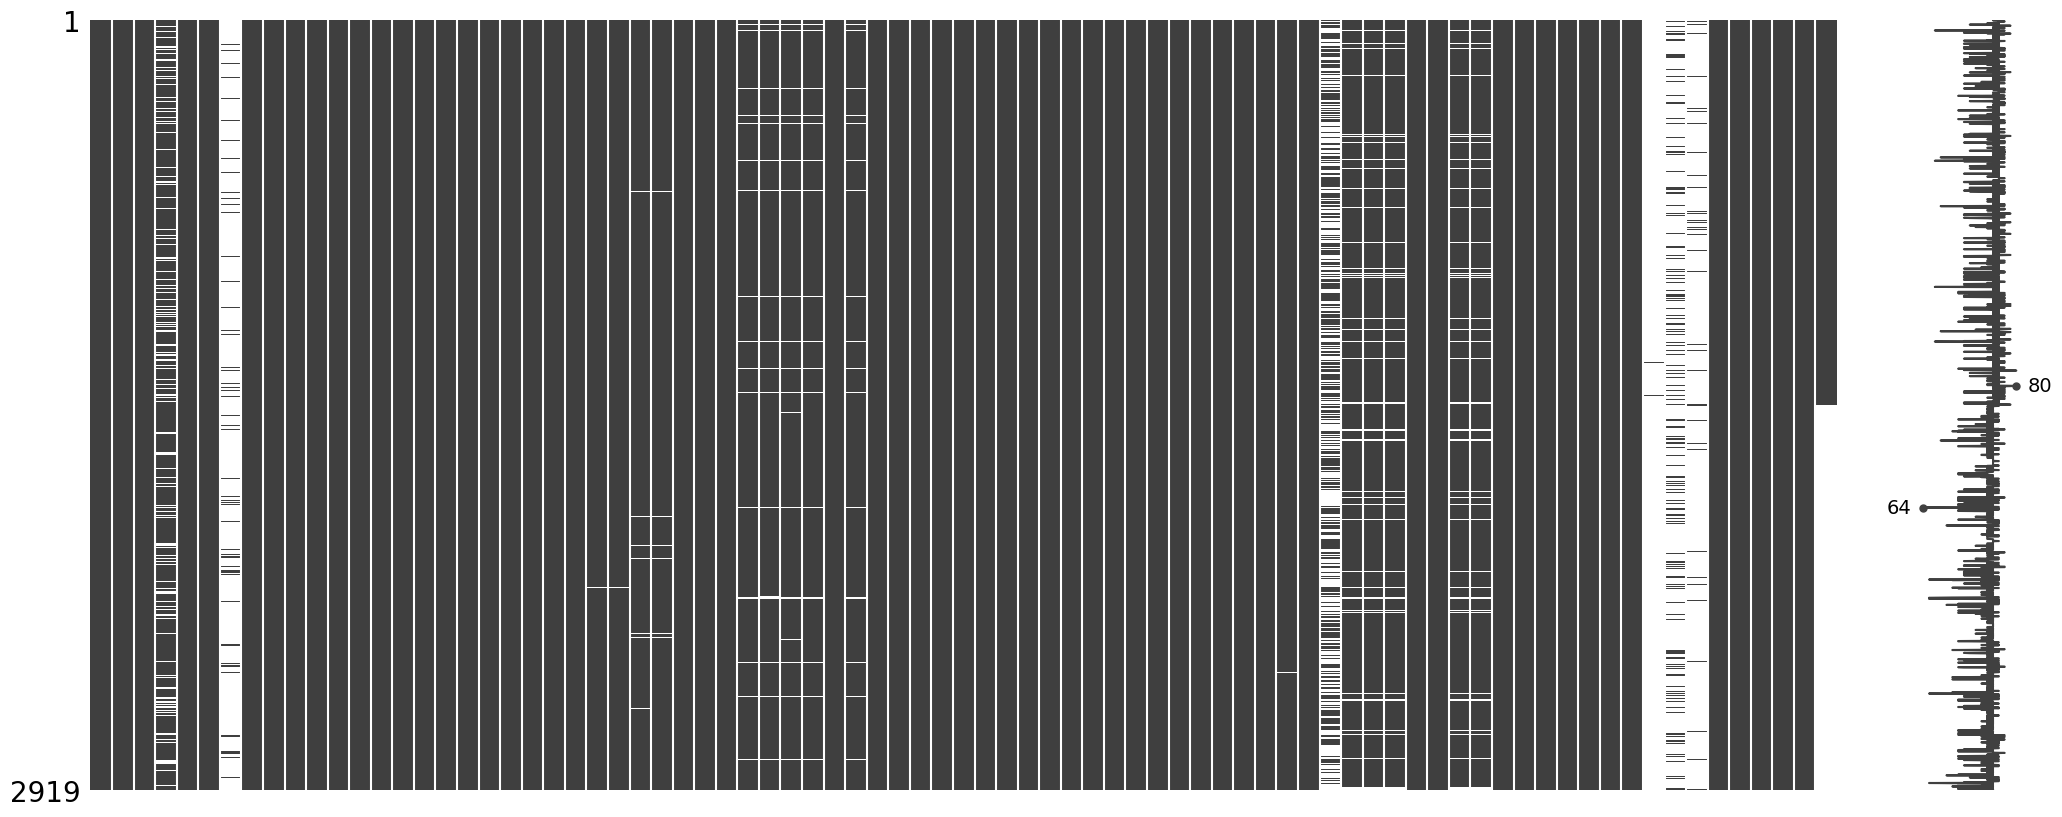

In [124]:
msno.matrix(all_data)

# 現時点でのスコアを確認する（0.13489）

### categorical や numerical の定義

In [125]:
target = "SalePrice"
feature_cols = all_data.columns.drop(target)

categorical_cols = []
numerical_cols = []
for i in feature_cols:
    if all_data[i].dtype=='object':
        categorical_cols.append(i)
    else:
        numerical_cols.append(i)
num_to_cat = []
num_to_cat.append("MSSubClass")

# numericalに誤分類されていたcategoricalを移動させる
for col in num_to_cat:
  categorical_cols.append(col)
  numerical_cols.remove(col)

print('Number of categorical features:', str(len(categorical_cols)))
print('Number of numerical features:', str(len(numerical_cols)))

Number of categorical features: 44
Number of numerical features: 36


In [126]:
print(categorical_cols)
print(numerical_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass']
['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', '

### BoxCox変換する特徴量を決める

In [128]:
# Check the skew of all numerical features
skewed_feats = all_data[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[skewness.abs() > 0.75]
skewness.dropna(inplace=True)
skewed_features = skewness.index.copy()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


Skew in numerical features: 

There are 21 skewed numerical features to Box Cox transform


### Preprocessor

In [129]:
# 量的変数の前処理
numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
skewed_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("power", PowerTransformer(method='yeo-johnson'))])

# カテゴリ変数の前処理
categorical_transformer = Pipeline(steps=[("cat_imputer", SimpleImputer(strategy="constant", fill_value="unknown")), ("encoder", OrdinalEncoder())])

# ColumnTransformerの作成
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, list(set(numerical_cols)-set(skewed_features))), ("cat", categorical_transformer, categorical_cols), ("skew", skewed_transformer, skewed_features)])

### Define Pipeline

In [143]:
model = lgb.LGBMRegressor()
pipe = Pipeline(steps=[('preprocessor',preprocessor),('model',model)])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BedroomAbvGr', 'Fireplaces',
                                                   'GarageCars', 'OverallQual',
                                                   'HalfBath', 'YearBuilt',
                                                   'BsmtFullBath',
                                                   'OverallCond', 'GarageArea',
                                                   'GarageYrBlt',
                                                   'YearRemodAdd', 'MoSold',
                                                   'Id', 'FullBath',
                                                   'YrSold']...
                                                                   PowerTransformer())]),
                                                  Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF',
       'LotFrontage', '1stFlrSF', 'BsmtFinSF1', 'GrLivArea', 'TotalBsmtSF',
       'BsmtUnfSF', '2ndFlrSF', 'TotRmsAbvGrd'],
      dtype='object'))])),
                ('model', LGBMRegressor())])

In [133]:
# preprocessor を Pipelineに含て Cross_validateするとエラーになるので、先に全データに対してPreprocessorをかける
all_data_preprocessed = pd.DataFrame(preprocessor.fit_transform(all_data), columns=get_feature_names(preprocessor))
all_data_preprocessed[target] = list(all_data[target])

In [134]:
train_X = all_data_preprocessed.iloc[:train.shape[0]][all_data_preprocessed.columns.drop(target)]
train_y = pd.DataFrame(all_data_preprocessed.iloc[:train.shape[0]][target], columns=[target])
test_X = all_data_preprocessed.iloc[train.shape[0]:][all_data_preprocessed.columns.drop(target)]

In [142]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model = lgb.LGBMRegressor()
scores = cross_validate(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise', return_estimator=False) # model の状態を確認したい場合はreturn_estimator をTrueにする
score_mean = mean(scores["test_score"])
print(f"score:{score_mean}")
scores

score:-29591.781595138582


{'fit_time': array([0.39157176, 0.44516969, 0.36186552, 0.36362982, 0.21887946]),
 'score_time': array([0.00802016, 0.00846338, 0.00811219, 0.00845194, 0.0062573 ]),
 'test_score': array([-32787.09024833, -28263.88821456, -27158.2192436 , -32611.75482914,
        -27137.95544007])}

### 予測結果を提出する

In [136]:
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
y_pred
output = pd.DataFrame({'Id': test["Id"],
                       'SalePrice': y_pred})

path = "/content/drive/MyDrive/Colab Notebooks/data/output.csv"
output.to_csv(path, index=False)
output

,Id,SalePrice
0,1461,125755.889991
1,1462,161939.801245
2,1463,180095.575544
3,1464,185476.285562
4,1465,199553.419602
...,...,...
1454,2915,78951.479182
1455,2916,84616.317882
1456,2917,164014.404945
1457,2918,115501.713017


# 個別の特徴量についてEDA

### BsmtUnfSF

#### 特徴量の概要

- 未完了の基礎の大きさ
- 量的変数

#### 分布の確認
- ほとんどの値が0（＝未完了となっている基礎はない）
- 未完成の基礎が広い（＝敷地が広い）場合には価格が高いことがある

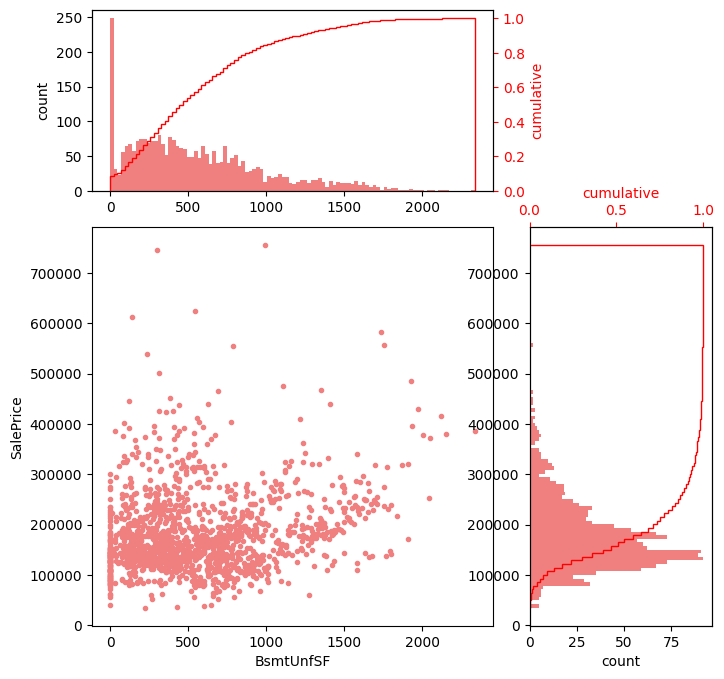

In [152]:
scatter_hist(all_data, "BsmtUnfSF", "SalePrice")

#### 欠損値の補完

In [155]:
all_data["BsmtUnfSF"].isna().sum()

1

In [174]:
# No basementの場合にはBsmtQualがNAとなる。
# 該当の１件はBsmtQualがNaNのため、基礎が存在しない。そのため0で補完するのが妥当といえる
cols = ["Id", "BsmtFinSF1", "BsmtUnfSF"]
all_data[all_data["BsmtUnfSF"].isna()].T

,660
Id,2121
MSSubClass,20
MSZoning,RM
LotFrontage,99.0
LotArea,5940
...,...
MoSold,4
YrSold,2008
SaleType,ConLD
SaleCondition,Abnorml


In [168]:
cols = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]
all_data[cols].isna().sum()

BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinSF1       1
BsmtFinType2    80
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
dtype: int64

In [172]:
all_data["BsmtQual"].value_counts()

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

In [173]:
all_data[all_data["BsmtQual"].isna()].T

,17,39,90,102,156,182,259,342,362,371,...,1118,1139,1242,1303,1306,1343,1344,1364,1431,1444
Id,18,40,91,103,157,183,260,343,363,372,...,2579,2600,2703,2764,2767,2804,2805,2825,2892,2905
MSSubClass,90,90,20,90,20,20,20,90,85,50,...,50,20,90,20,90,20,30,20,30,20
MSZoning,RL,RL,RL,RL,RL,RL,RM,RL,RL,RL,...,RM,RL,RM,RL,RL,RL,RL,RL,C (all),NaN
LotFrontage,72.0,65.0,60.0,64.0,60.0,60.0,70.0,NaN,64.0,80.0,...,64.0,200.0,68.0,86.0,60.0,100.0,55.0,80.0,69.0,125.0
LotArea,10791,6040,7200,7018,7200,9060,12702,8544,7301,17120,...,11067,43500,8927,11650,8544,21370,8250,12048,12366,31250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MoSold,10,6,7,6,6,6,12,5,7,7,...,3,6,8,6,12,6,6,4,10,5
YrSold,2006,2008,2006,2009,2006,2007,2008,2006,2009,2008,...,2007,2007,2006,2006,2006,2006,2006,2006,2006,2006
SaleType,WD,WD,WD,WD,WD,WD,WD,WD,ConLD,WD,...,WD,WD,WD,WD,WD,WD,WD,WD,WD,WD
SaleCondition,Normal,AdjLand,Normal,Alloca,Normal,Normal,Normal,Normal,Normal,Normal,...,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Abnorml,Normal


#### 外れ値の除外

#### 何かいい感じの特徴量を新しく作れないか？
- Totalに対する割合を算出するのがいいかもしれない。

### TotalBsmtSF

#### 分布の確認

#### 欠損値の補完

#### 外れ値の除外

#### 何かいい感じの特徴量を新しく作れないか？

#### 分布の確認

#### 欠損値の補完

#### 外れ値の除外

#### 何かいい感じの組み合わせを作れないか？

### 1stFlrSF

### GrLivArea

### GarageArea

## 分布の確認

#### Target の確認(Dependent, Nominal)

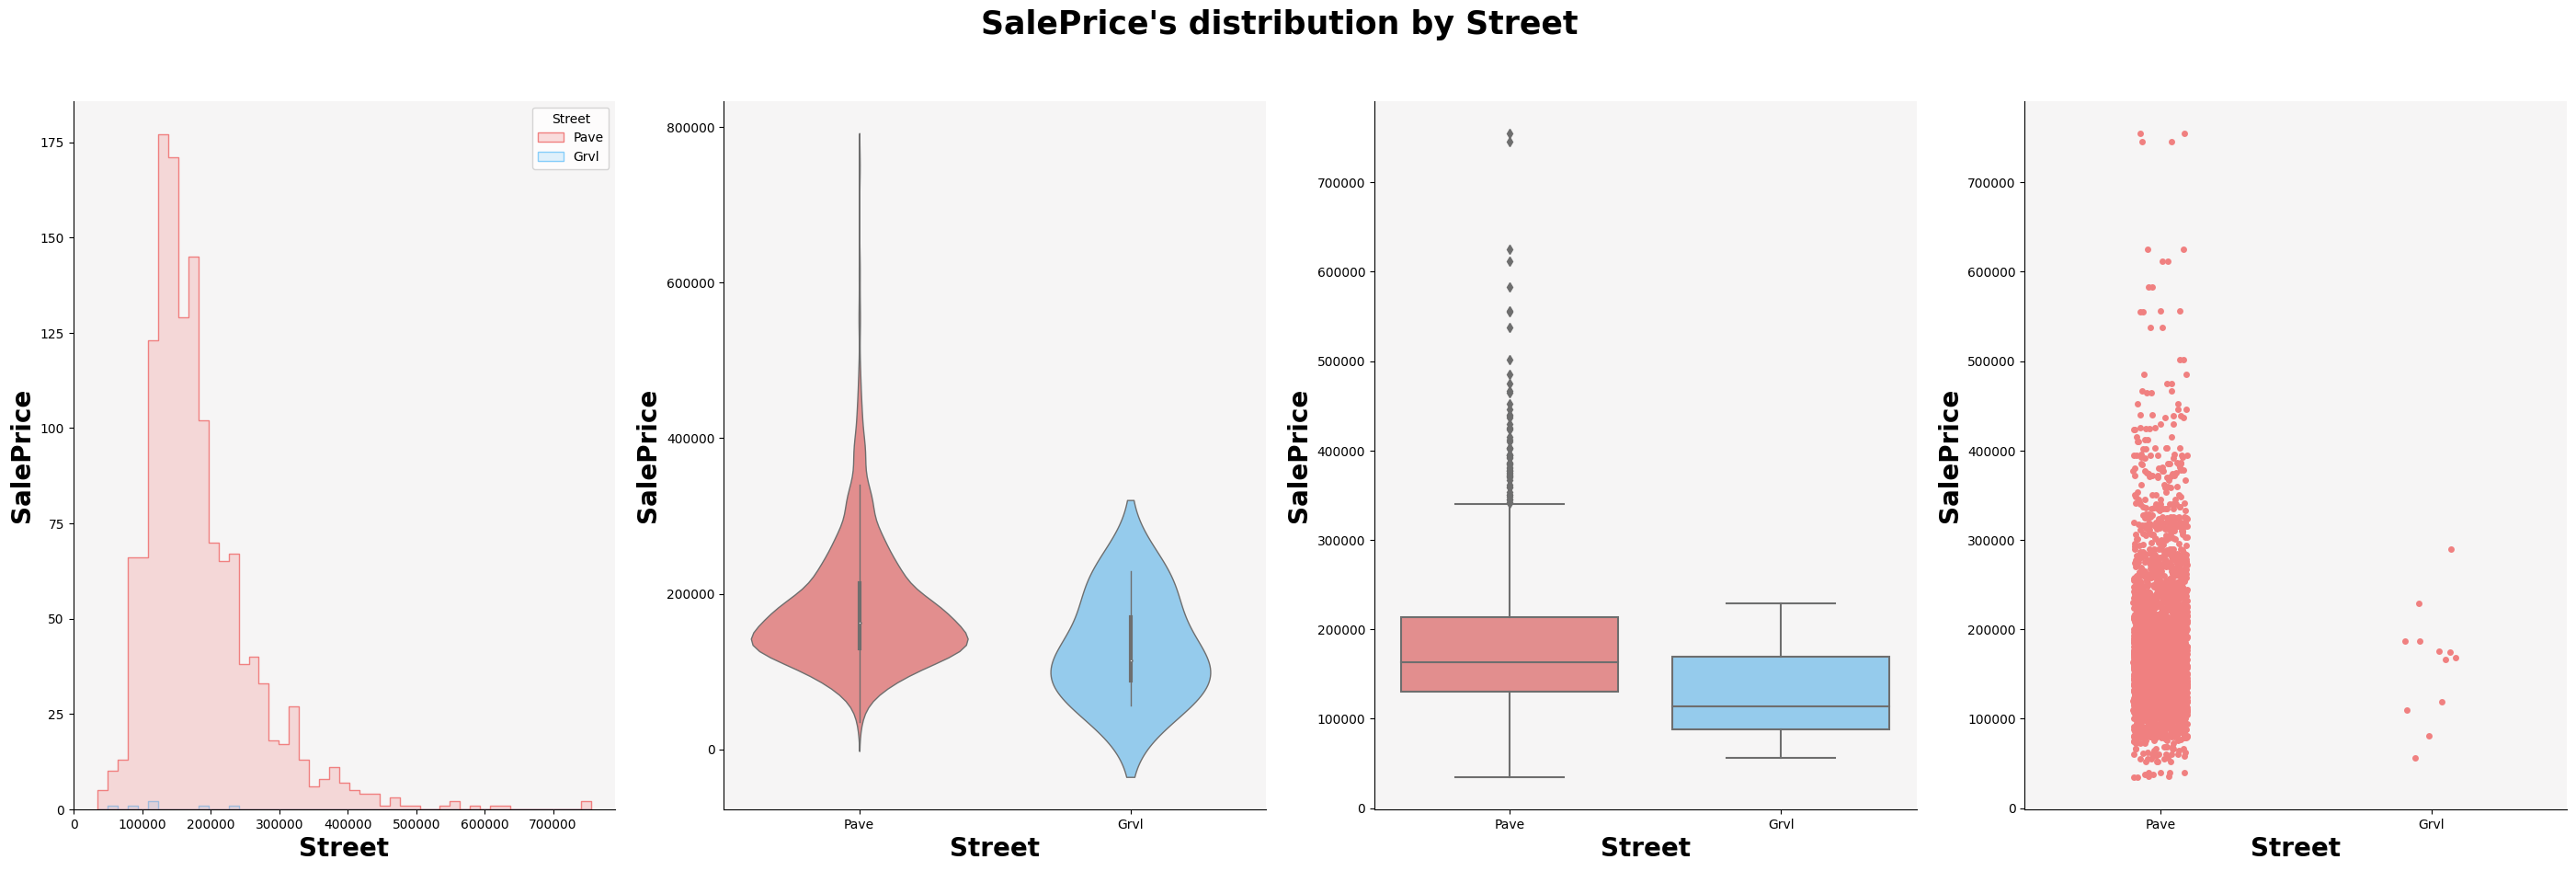

In [137]:
continuous_dist(all_data, "Street", "SalePrice")